In [1]:
import numpy as np
import tqdm
import scipy
import pickle
from scipy.stats import percentileofscore, rankdata
import tools
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from matplotlib import cm
from matplotlib.ticker import LinearLocator

In [2]:
def get_k(rho):
    
    """Generates a thermal conductivity (W/m3/K) from density.
    
    This is the heat that flows per second through 1m2 area 
    per metre of thickness per degree of temperature difference.
    
    From Calonne et al. (2011).
    
    https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2011GL049234
    
    """
    
    k = ( 2.5 * 10**(-6) * rho**2 ) - (1.23 * 10**(-4) * rho ) + 0.024
    
    return k

def get_abs_k(depth, k_per_metre):
    
    """This generates the absolute thermal conductivity for snow of given depth.
    
    This is the heat that flows through a square metre of snow per degree of temp diff.
    
    """

    k_abs = k_per_metre / depth
    
    return k_abs #W/m2K

k_per_metre = get_k(300)

In [3]:
statistics = {'a': 2.542562886886376,
  'loc': -1.114525560819975,
  'scale': 1.4973819434202296,
  'CV': 0.41696167189340216,
  'n': 33539}

### Generate an effective conductivity of a distributed snowpack *without* accounting for cold patches

To do this we:

- Generate a binned snow depth distribution based on the mean snow depth.

- For each snow depth bin we calculate the absolute thermal conductivity based on its depth and the *temperature difference across the slab*.

- We then perform a weighted average of all the absolute thermal conductivities, weighting the average with the areal coverage of the snow-depth-bin.

This is the *effective* thermal conductivity of the snow pack. That is, it corresponds to the thermal conductivity of a slab of that depth that would have the same heat flux as the distributed snow pack.

We can express this effective thermal conductivity as a multiplying factor on a uniform depth snow pack with a depth corresponding to the mean snow depth in the model grid cell.

Both the effective thermal conductivity and the multiplier are functions of the mean snow depth.

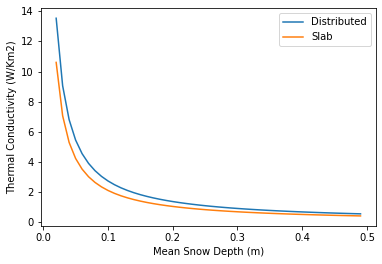

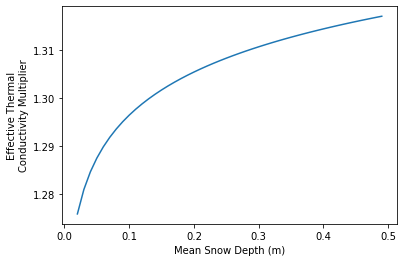

In [4]:
bin_width = 0.002
bin_edges = np.arange(0,2,bin_width)

k_slab = []
k_eff = []

mean_depths = np.arange(0.02,0.5,0.01)

for mean_depth in mean_depths:
    
    depth_bins, probability = tools.depth_distribution_from_depth(mean_depth=mean_depth,
                                                           dep_bin_edges=bin_edges,
                                                       statistics=statistics)

    conductivity_bins = get_abs_k(depth_bins, k_per_metre)
    
    dist_cond = np.sum(np.multiply(conductivity_bins,probability))
    
    k_eff.append( dist_cond )
    k_slab.append( k_per_metre/mean_depth )
                               
        
multiplier = np.array(k_eff)/np.array(k_slab)

plt.plot(mean_depths, k_eff, label='Distributed')                            
plt.plot(mean_depths, k_slab, label='Slab')
plt.ylabel('Thermal Conductivity (W/Km2)')
plt.xlabel('Mean Snow Depth (m)')
plt.legend()
plt.show()

plt.plot(mean_depths,multiplier)
plt.ylabel('Effective Thermal\nConductivity Multiplier')
plt.xlabel('Mean Snow Depth (m)')
plt.show()

In [5]:
def calc_ice_surface_temp(T_as, #Temp_air_snow
                               H_s, #Snow_height
                               H_i, #Ice_thickness
                               k_s, #Snow_thermal_conductivity
                               k_i, #Ice_thermal_conductivity
                               ):
    
    """Calculates the temperature of the snow-ice interface.
    
    This temperature is set by the heat flux through the ice and through the snow. 
    If heat flows faster through the ice, it goes up. If it flows faster through the
    snow, it goes down. The above rates are dictated by the snow/ice thermal conductivities,
    the layer thicknesses, and the boundary-temperatures (air-snow and ice-water temps).
    
    I've calculated the equation in the back of my black rubber-covered notebook.
    
    """
    
    zero_K = 273.15
    
    T_iw = -1.8 + zero_K # Ice-water temperature
    
    # Calculate snow_ice interface temp

    T_si = ( (T_as * k_s * H_i) + (H_s * k_i * T_iw) ) / ( (H_s * k_i) + (k_s * H_i) )
    
    return T_si


def heat_through_snow_1D(T_as, #Temp_air_snow
                       H_s, #Snow_height
                       H_i, #Ice_thickness
                       k_s, #Snow_thermal_conductivity
                       k_i,
                     ):
    
    """Calculates the heat flux through snow of a given depth.
    
    This is based on boundary conditions and snow geophysics.
    """
    
    
    T_si = calc_ice_surface_temp(T_as, #Temp_air_snow
                               H_s, #Snow_height
                               H_i, #Ice_thickness
                               k_s, #Snow_thermal_conductivity
                               k_i, #Ice_thermal_conductivity
                               )

    temp_diff = T_si - T_as
    
    heat_flux = (k_s * temp_diff) / H_s
    
    return (heat_flux, T_si)

### Generate an effective conductivity of a distributed snowpack *with* accounting for cold patches

To do this we:

- Generate a binned snow depth distribution based on the mean snow depth.

- For each snow depth bin we calculate the heat flux through the snow. This is a function of its depth, which in turn impacts the temperature of the snow-ice interface.

- We then perform a weighted average of all the heat fluxes, weighting the average with the areal coverage of the snow-depth-bin.

- Now knowing the average heat flux of the snowpack, we can caluculate its *effective* thermal conductivity by dividing by the average heat flux by the temperature difference across the slab.

The *effective* thermal conductivity of the snow pack is higher than the slab, but lower than in the naive case. This is because the average snow-ice interface temperature is lower than for the slab, reducing the temperature gradient across the snow. 

Both the effective thermal conductivity and the multiplier are functions of the mean snow depth and the ice thickness.

In [6]:
def get_k_patches(mean_depth, ice_thickness):
    
    """Gets the """
    
    depth_bins, probability = tools.depth_distribution_from_depth(mean_depth=mean_depth,
                                                           dep_bin_edges=bin_edges,
                                                       statistics=statistics)


    heat_fluxes, temp_diffs = heat_through_snow_1D(T_as=T_as,
                               H_s=depth_bins,
                               H_i=ice_thickness,
                               k_i=2,
                               k_s=k_per_metre,
                              )

    int_heat_fluxes = np.sum(np.multiply(heat_fluxes,probability))
    
    int_temp_diffs = np.sum(np.multiply(temp_diffs,probability))

    # Calculate heat flux through slab

    heat_flux_slab, slab_temp_diff = heat_through_snow_1D(T_as=T_as,
                                          H_s=mean_depth,
                                          H_i=ice_thickness,
                                          k_i=2,
                                          k_s=k_per_metre)


    # Calculate effective values

    delta_T_slab = calc_ice_surface_temp(T_as=T_as,
                                            H_s=mean_depth,
                                            H_i=ice_thickness,
                                            k_i=2,
                                            k_s=k_per_metre) - T_as

    return (int_heat_fluxes, heat_flux_slab, delta_T_slab, int_temp_diffs)

# Calculate effective thermal conducitivity for many snowpacks of different mean depths and ice thicknesses

In [7]:
T_as = -20

bin_width = 0.001
bin_edges = np.arange(0,2,bin_width)

ice_thicknesses = np.arange(0.1,2.6,0.01)
mean_depths = np.arange(0.02,0.5,0.01)

multi_k = []

for ice_thickness in ice_thicknesses:
    
    eff_conductivities = []

    for mean_depth in mean_depths:
        
        (int_heat_fluxes, heat_flux_slab, delta_T_slab, int_temp_diffs) = get_k_patches(mean_depth, ice_thickness)
        
        # Get depth distribution

        k_eff = int_heat_fluxes * mean_depth / delta_T_slab
        k_slab = heat_flux_slab * mean_depth / delta_T_slab
        
        eff_conductivities.append( k_eff/k_per_metre)

        if np.isclose(ice_thickness,1):
            if np.isclose(mean_depth,0.3):
                print(k_eff)
                print(k_slab)
                print(k_eff/k_slab)
                print(k_eff/k_per_metre)        
            
#         if k_eff/k_per_metre > 1.2: print(ice_thickness,mean_depth)
        
    multi_k.append( eff_conductivities)
    
multi_k = np.array(multi_k)

0.23414612713536334
0.21209999999999998
1.1039421364232125
1.1039421364232125


# Plot effective conductivity multiplier as a function of mean depth and ice thickness

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: The following kwargs were not used by contour: 'aspect'
  """Entry point for launching an IPython kernel.


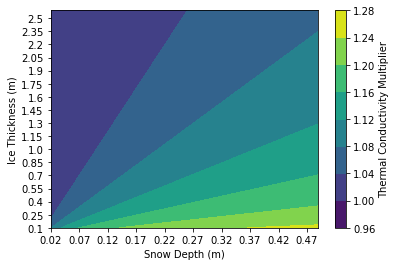

In [8]:
plt.contourf(multi_k,aspect='auto')
plt.xticks(np.arange(0,multi_k.shape[1],5),
           labels=np.round(mean_depths[::5],decimals=3))

ytickspacer = 15

plt.yticks(np.arange(0,multi_k.shape[0],ytickspacer),
           labels=np.round(ice_thicknesses[::ytickspacer],decimals=3))
plt.xlabel('Snow Depth (m)')
plt.ylabel('Ice Thickness (m)')
plt.colorbar(label='Thermal Conductivity Multiplier')

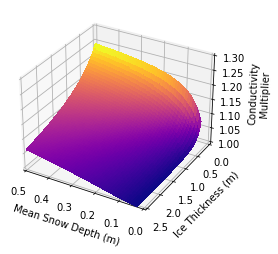

In [9]:
Z = np.array(multi_k)
X, Y = np.meshgrid(mean_depths,ice_thicknesses)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

surf = ax.plot_surface(X, Y, Z, cmap=cm.plasma,
                       linewidth=0, antialiased=False)

ax.set_zlim(1, 1.3)

ax.set_xlabel('Mean Snow Depth (m)')
ax.set_ylabel('Ice Thickness (m)')
ax.set_zlabel('Conductivity\nMultiplier',labelpad=8)

ax.set_xlim(0.5,0)
ax.set_ylim(2.5,0)

plt.show()

# Remake the 2D function with wider input space ready for fitting with a 2D function

In [10]:
bin_width = 0.001
bin_edges = np.arange(0,2,bin_width)

ice_thicknesses = np.arange(0.1,5,0.01)
mean_depths = np.arange(0.02,1.5,0.01)

multi_k = []

for ice_thickness in ice_thicknesses:
    
    eff_conductivities = []

    for mean_depth in mean_depths:
        
        (int_heat_fluxes, heat_flux_slab, delta_T_slab, x) = get_k_patches(mean_depth, ice_thickness)
        
        # Get depth distribution

        k_eff = int_heat_fluxes * mean_depth / delta_T_slab
        k_slab = heat_flux_slab * mean_depth / delta_T_slab
        
        eff_conductivities.append( k_eff/k_per_metre)

        if np.isclose(ice_thickness,1):
            if np.isclose(mean_depth,0.3):
                print(k_eff)
                print(k_slab)
                print(k_eff/k_slab)
                print(k_eff/k_per_metre)        

    multi_k.append( eff_conductivities)
    
multi_k = np.array(multi_k)

Z = np.array(multi_k)
X, Y = np.meshgrid(mean_depths,ice_thicknesses)

0.23414612713536334
0.21209999999999998
1.1039421364232125
1.1039421364232125


# Make fancy paper plot

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning: The following kwargs were not used by contour: 'aspect'
  after removing the cwd from sys.path.


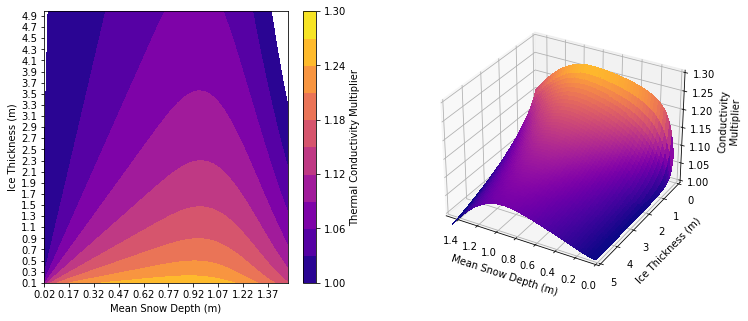

In [17]:
%matplotlib inline
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,5))

cf = ax1.contourf(multi_k,aspect='auto',cmap='plasma',vmin=1,vmax=1.3,levels=np.arange(1,1.321,0.03))

ax1.set_xlabel('Mean Snow Depth (m)')
ax1.set_ylabel('Ice Thickness (m)')

fig.colorbar(cf, label='Thermal Conductivity Multiplier',ax=ax1)

###

ax2.remove()

ax2 = fig.add_subplot(1,2,2,projection = "3d")

surf = ax2.plot_surface(X, Y, Z, cmap=cm.plasma, vmin=1,vmax=1.3,
                       linewidth=0, antialiased=False)

ax2.set_zlim(1, 1.3)

ax2.set_xlabel('Mean Snow Depth (m)')
ax2.set_ylabel('Ice Thickness (m)')
ax2.set_zlabel('Conductivity\nMultiplier',labelpad=8)


ax2.set_xlim(1.5,0)
ax2.set_ylim(5,0)

xtickspacer=15
ax1.set_xticks(np.arange(0,multi_k.shape[1],xtickspacer))
ax1.set_xticklabels(np.round(mean_depths[::xtickspacer],decimals=3))
ytickspacer = 20
ax1.set_yticks(np.arange(0,multi_k.shape[0],ytickspacer))
ax1.set_yticklabels(np.round(ice_thicknesses[::ytickspacer],decimals=3))


odir = '/home/robbie/Dropbox/Apps/Overleaf/Conductivity/'

plt.savefig(f'{odir}surf_3d.jpg',bbox_inches='tight',dpi=400)

plt.show()

# Fit a 2d polynomial function to the results

This function can then be rapidly called within a complex model.

In [26]:
Z = np.array(multi_k)
X, Y = np.meshgrid(mean_depths,ice_thicknesses)

poly = PolynomialFeatures(degree=3)
input_pts = np.stack([X.flatten(), Y.flatten()]).T
in_features = poly.fit_transform(input_pts)

model = LinearRegression()
model.fit(in_features, Z.flatten())
print('x0 is snow depth, x1 is ice thickness')
print(dict(zip(poly.get_feature_names(), model.coef_.round(4))))
print(f"R-squared: {model.score(poly.transform(input_pts), Z.flatten()):.3f}")

Z_predicted = model.predict(poly.transform(input_pts))
Z_p = Z_predicted.reshape(Z.shape)

x0 is snow depth, x1 is ice thickness
{'1': 0.0, 'x0': 0.2736, 'x1': -0.113, 'x0^2': -0.0323, 'x0 x1': -0.0241, 'x1^2': 0.0311, 'x0^3': -0.0911, 'x0^2 x1': 0.0213, 'x0 x1^2': -0.0031, 'x1^3': -0.0027}
R-squared: 0.987


Here it is output in case above cell doesn't run:

x0 is snow depth, x1 is ice thickness
{'1': 0.0, 'x0': 0.2736, 'x1': -0.113, 'x0^2': -0.0323, 'x0 x1': -0.0241, 'x1^2': 0.0311, 'x0^3': -0.0911, 'x0^2 x1': 0.0213, 'x0 x1^2': -0.0031, 'x1^3': -0.0027}
R-squared: 0.987

# Here is the parameterization!

Put in terms of:
- z : thermal conductivity multiplyer
- x : mean snow depth
- y : ice_thickness

$z = 0 + 0.2736x + -0.113y + -0.0323x^2 + -0.0241xy + 0.0311y^2 + -0.0911x^3 + 0.0213x^2y + -0.0031xy^2 + -0.0027y^3$

# Plot the error in the cubic fit to the data

/home/robbie/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: The following kwargs were not used by contour: 'aspect'
  


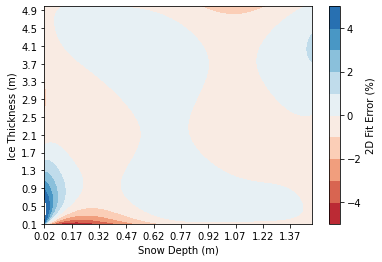

In [27]:
%matplotlib inline
plt.contourf(100*np.divide((Z_p-Z),Z),aspect='auto',cmap='RdBu',vmin=-6,vmax=6,levels=np.arange(-5,5.1,1))

xtickspacer=15

plt.xticks(np.arange(0,multi_k.shape[1],xtickspacer),
           labels=np.round(mean_depths[::xtickspacer],decimals=3))

ytickspacer = 40

plt.yticks(np.arange(0,Z.shape[0],ytickspacer),
           labels=np.round(ice_thicknesses[::ytickspacer],decimals=3))

plt.xlabel('Snow Depth (m)')
plt.ylabel('Ice Thickness (m)')
plt.colorbar(label='2D Fit Error (%)')